In [67]:
# importing all neccesssary libraries.
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random



In [25]:
from collections import defaultdict

class Federated_base:

    def __init__(self, num_clients, X_train, y_train, X_test, y_test):
        self.num_clients = num_clients
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def create_clients_iid(self, initial="entity"):
        ''' 
        Creates an IID data distribution for clients.

        Returns:
            Dictionary with keys as client's name and values as lists of indices.
        '''
        # Creates a list of all client names using the "initial"
        client_names = ['{}_{}'.format(initial, i+1) for i in range(self.num_clients)]

        indices = list(range(len(self.X_train)))
        random.shuffle(indices)

        size = len(indices) // self.num_clients
        shards = [indices[i:i + size] for i in range(0, size * self.num_clients, size)]

        # Number of clients must equal number of shards
        assert len(shards) == len(client_names)

        return {client_names[i]: shards[i] for i in range(len(client_names))}

    def create_clients_dirichlet(self, alpha=0.5):
        ''' 
        Creates a non-IID data distribution using Dirichlet distribution for clients.

        Returns:
            Dictionary with keys as client's name and values as lists of indices.
        '''
        # Create the dictionary to store clients' data
        non_iid_clients = defaultdict(list)

        # Get unique labels and their indices
        unique_labels, label_indices = np.unique(self.y_train, return_inverse=True)

        # Number of classes
        num_classes = len(unique_labels)

        # Generate Dirichlet distribution for each class
        class_distribution = np.random.dirichlet([alpha] * self.num_clients, num_classes)

        # Assign data points to clients based on the Dirichlet distribution
        for class_idx, class_dist in enumerate(class_distribution):
            class_data_indices = np.where(label_indices == class_idx)[0]
            random.shuffle(class_data_indices)

            # Convert class_dist proportions to integer counts
            class_dist_counts = (len(class_data_indices) * class_dist).astype(int)
            class_split = np.split(class_data_indices, np.cumsum(class_dist_counts)[:-1])

            for client_idx, indices in enumerate(class_split):
                non_iid_clients[f'client_{client_idx}'].extend(indices)

        return non_iid_clients



In [26]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

# CIFAR 10 Dataset and Partition

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
num_clients = 10
X_train = trainset.data
y_train = np.array(trainset.targets)
X_test = testset.data
y_test = np.array(testset.targets)

federated = Federated_base(num_clients, X_train, y_train, X_test, y_test)

# Create IID client datasets
clients_iid = federated.create_clients_iid()

# Optionally, create non-IID client datasets
clients_non_iid = federated.create_clients_dirichlet(alpha=0.5)

In [30]:
# Wrap IID client datasets using DatasetSplit
client_datasets_iid = {client: DatasetSplit(trainset, indices)
                       for client, indices in clients_iid.items()}

# Wrap non-IID client datasets using DatasetSplit
client_datasets_non_iid = {client: DatasetSplit(trainset, indices)
                           for client, indices in clients_non_iid.items()}


In [31]:
# Create DataLoaders for each client
client_loaders_iid = {client: DataLoader(dataset, batch_size=32, shuffle=True)
                      for client, dataset in client_datasets_iid.items()}

client_loaders_non_iid = {client: DataLoader(dataset, batch_size=32, shuffle=True)
                          for client, dataset in client_datasets_non_iid.items()}

# Visualization of our data

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


def count_class_samples(client_datasets, num_classes):
    client_class_counts = {client: np.zeros(num_classes, dtype=int) for client in client_datasets.keys()}

    for client, dataset in client_datasets.items():
        for _, label in dataset:
            client_class_counts[client][label] += 1

    return client_class_counts

import pandas as pd

def display_class_distribution_heatmap(client_class_counts, num_classes, title):
    # Create a DataFrame from the client class counts
    df = pd.DataFrame(client_class_counts).T
    df.columns = [f'Class_{i}' for i in range(num_classes)]
    
    # Add a total column
    df['Total'] = df.sum(axis=1)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt='d')
    plt.title(title)
    plt.show()



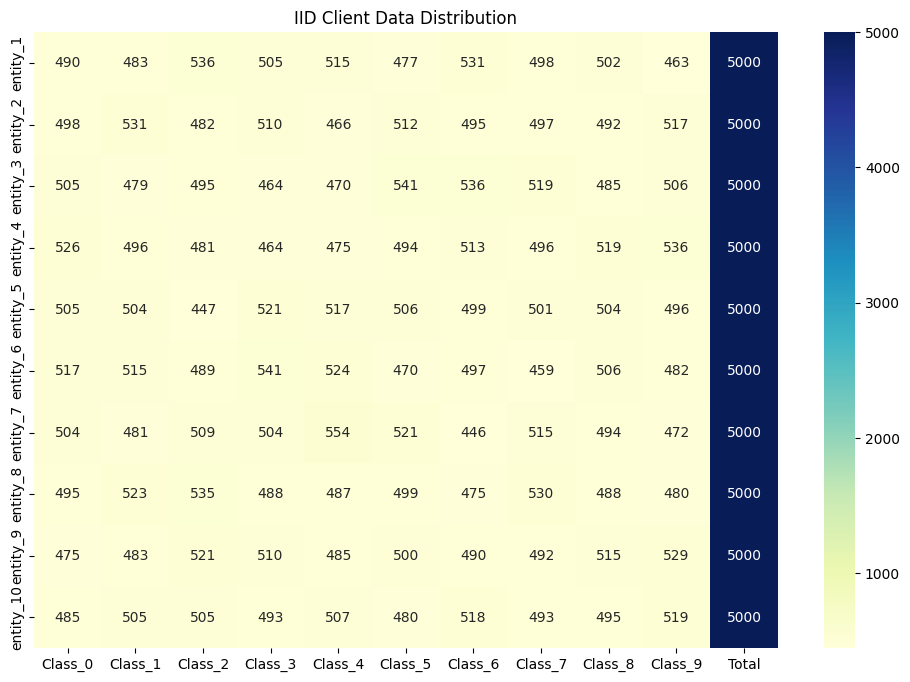

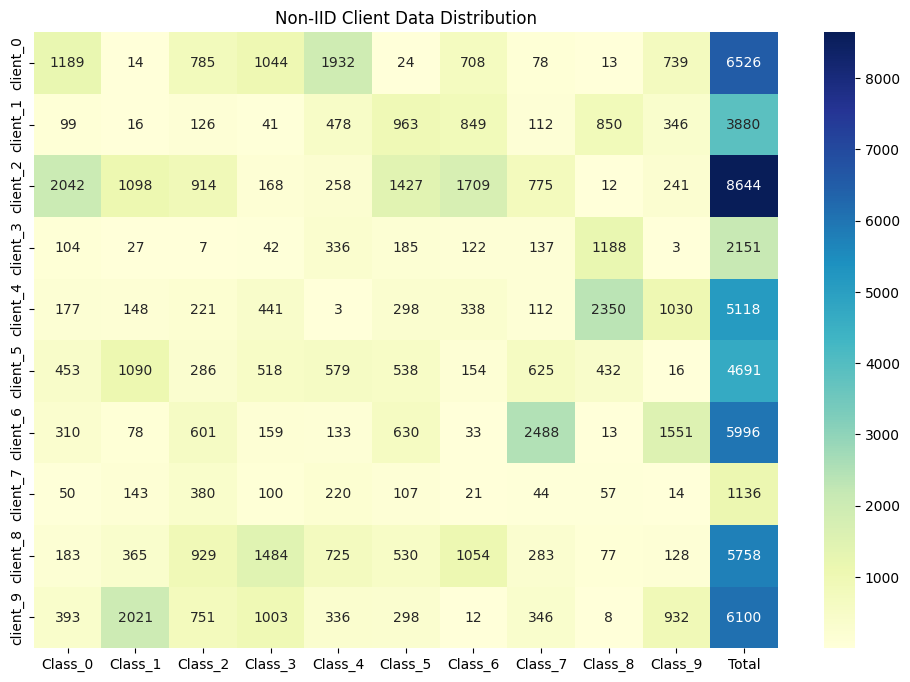

In [39]:
# Count samples per class for IID datasets
num_classes = 10
client_class_counts_iid = count_class_samples(client_datasets_iid, num_classes)

# Count samples per class for non-IID datasets
client_class_counts_non_iid = count_class_samples(client_datasets_non_iid, num_classes)

# Display IID distribution
display_class_distribution_heatmap(client_class_counts_iid, num_classes, "IID Client Data Distribution")

# Display non-IID distribution
display_class_distribution_heatmap(client_class_counts_non_iid, num_classes, "Non-IID Client Data Distribution")

Training

In [58]:


import matplotlib.pyplot as plt

class FederatedTraining:
    def __init__(self, model, device, trainset, testset, num_clients, iid=True, alpha=0.5):
        self.model = model
        self.device = device
        self.trainset = trainset
        self.testset = testset
        self.num_clients = num_clients
        self.iid = iid
        self.alpha = alpha

        self.federated = Federated_base(num_clients, trainset.data, trainset.targets, testset.data, testset.targets)
        self.clients = self.federated.create_clients_iid() if iid else self.federated.create_clients_dirichlet(alpha)
        self.client_datasets = {client: DatasetSplit(trainset, indices) for client, indices in self.clients.items()}
        self.test_loader = DataLoader(testset, batch_size=32, shuffle=False)  # Fixed batch size for testing

    def train(self, epochs, lr, batch_size):
        self.model.to(self.device)
        criterion = nn.CrossEntropyLoss()

        self.client_loaders = {client: DataLoader(dataset, batch_size=batch_size, shuffle=True) 
                               for client, dataset in self.client_datasets.items()}
        
        accuracy_list = []
        
        for epoch in range(epochs):
            client_models = []
            for client, loader in self.client_loaders.items():
                client_model = SimpleCNN().to(self.device)
                client_model.load_state_dict(self.model.state_dict())
                optimizer = optim.SGD(client_model.parameters(), lr=lr)

                client_model.train()
                for images, labels in loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    output = client_model(images)
                    loss = criterion(output, labels)
                    loss.backward()
                    optimizer.step()

                client_models.append(client_model.state_dict())
            
            # Federated averaging
            new_state_dict = self.model.state_dict()
            for key in new_state_dict.keys():
                new_state_dict[key] = torch.stack([client_model[key].float() for client_model in client_models], 0).mean(0)
            self.model.load_state_dict(new_state_dict)

            # Evaluate the model
            test_loss, accuracy = self.evaluate()
            accuracy_list.append(accuracy)
            print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
        return accuracy_list

    def evaluate(self):
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        test_loss = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                test_loss += criterion(output, labels).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()
        
        test_loss /= len(self.test_loader.dataset)
        accuracy = 100. * correct / len(self.test_loader.dataset)
        return test_loss, accuracy


In [ ]:
DEVICE = torch.device("mps")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__}"
)

Training on mps using PyTorch 2.1.2


In [52]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*6*6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [54]:
model = SimpleCNN()

# Initialize the FederatedTraining class
federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients=10, iid=True, alpha=0.5, batch_size=64)

# Train the model
federated_training.train(epochs=10, lr=0.01)



Epoch 1, Test Loss: 0.0360, Accuracy: 15.12%
Epoch 2, Test Loss: 0.0358, Accuracy: 18.24%
Epoch 3, Test Loss: 0.0354, Accuracy: 21.04%
Epoch 4, Test Loss: 0.0347, Accuracy: 25.32%
Epoch 5, Test Loss: 0.0336, Accuracy: 26.67%
Epoch 6, Test Loss: 0.0324, Accuracy: 28.06%
Epoch 7, Test Loss: 0.0315, Accuracy: 29.12%
Epoch 8, Test Loss: 0.0309, Accuracy: 30.73%
Epoch 9, Test Loss: 0.0303, Accuracy: 32.22%
Epoch 10, Test Loss: 0.0297, Accuracy: 33.43%


In [65]:
def plot_accuracies(batch_sizes, accuracies):
    for batch_size, accuracy in zip(batch_sizes, accuracies):
        plt.plot(range(1, len(accuracy)+1), accuracy, label=f'alpha = {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Federated Learning Accuracy for Different alpha (Dirichlit)')
    plt.legend()
    plt.show()

For Batch size:  16
Epoch 1, Test Loss: 0.0700, Accuracy: 25.23%
Epoch 2, Test Loss: 0.0625, Accuracy: 29.57%
Epoch 3, Test Loss: 0.0587, Accuracy: 33.56%
Epoch 4, Test Loss: 0.0562, Accuracy: 36.52%
Epoch 5, Test Loss: 0.0534, Accuracy: 39.74%
Epoch 6, Test Loss: 0.0506, Accuracy: 42.82%
Epoch 7, Test Loss: 0.0485, Accuracy: 45.06%
Epoch 8, Test Loss: 0.0469, Accuracy: 46.68%
Epoch 9, Test Loss: 0.0456, Accuracy: 48.34%
Epoch 10, Test Loss: 0.0443, Accuracy: 49.68%
Epoch 11, Test Loss: 0.0434, Accuracy: 50.50%
Epoch 12, Test Loss: 0.0425, Accuracy: 51.50%
Epoch 13, Test Loss: 0.0420, Accuracy: 52.14%
Epoch 14, Test Loss: 0.0411, Accuracy: 53.45%
Epoch 15, Test Loss: 0.0404, Accuracy: 54.04%
Epoch 16, Test Loss: 0.0399, Accuracy: 55.08%
Epoch 17, Test Loss: 0.0394, Accuracy: 55.35%
Epoch 18, Test Loss: 0.0386, Accuracy: 56.34%
Epoch 19, Test Loss: 0.0381, Accuracy: 56.98%
Epoch 20, Test Loss: 0.0377, Accuracy: 57.29%
Epoch 21, Test Loss: 0.0371, Accuracy: 58.15%
Epoch 22, Test Loss: 0.

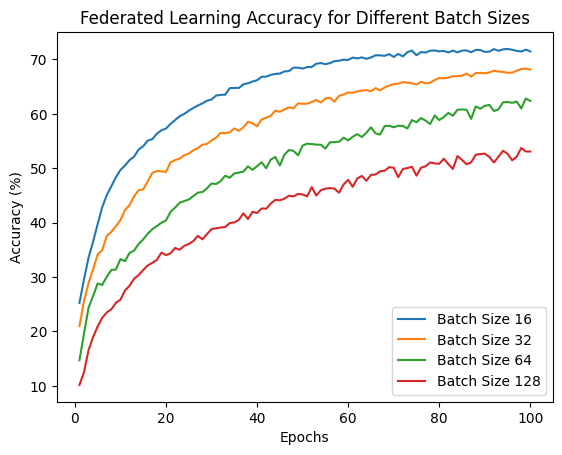

In [62]:
num_clients = 10
epochs = 100
lr = 0.01
batch_sizes = [16, 32, 64, 128]

accuracies = []
for batch_size in batch_sizes:
    model = SimpleCNN()
    
    print("For Batch size: ", batch_size)
    federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=True, alpha=0.5)
    accuracy = federated_training.train(epochs, lr, batch_size)
    accuracies.append(accuracy)

plot_accuracies(batch_sizes, accuracies)

For Batch size:  16
Epoch 1, Test Loss: 0.0686, Accuracy: 18.60%
Epoch 2, Test Loss: 0.0622, Accuracy: 27.89%
Epoch 3, Test Loss: 0.0585, Accuracy: 32.39%
Epoch 4, Test Loss: 0.0558, Accuracy: 35.59%
Epoch 5, Test Loss: 0.0539, Accuracy: 38.00%
Epoch 6, Test Loss: 0.0517, Accuracy: 39.76%
Epoch 7, Test Loss: 0.0494, Accuracy: 43.19%
Epoch 8, Test Loss: 0.0483, Accuracy: 44.42%
Epoch 9, Test Loss: 0.0471, Accuracy: 46.01%
Epoch 10, Test Loss: 0.0465, Accuracy: 45.88%
Epoch 11, Test Loss: 0.0453, Accuracy: 47.73%
Epoch 12, Test Loss: 0.0450, Accuracy: 48.48%
Epoch 13, Test Loss: 0.0437, Accuracy: 50.25%
Epoch 14, Test Loss: 0.0431, Accuracy: 50.74%
Epoch 15, Test Loss: 0.0424, Accuracy: 51.54%
Epoch 16, Test Loss: 0.0428, Accuracy: 51.74%
Epoch 17, Test Loss: 0.0411, Accuracy: 53.28%
Epoch 18, Test Loss: 0.0407, Accuracy: 54.05%
Epoch 19, Test Loss: 0.0404, Accuracy: 54.33%
Epoch 20, Test Loss: 0.0398, Accuracy: 54.75%
Epoch 21, Test Loss: 0.0394, Accuracy: 54.79%
Epoch 22, Test Loss: 0.

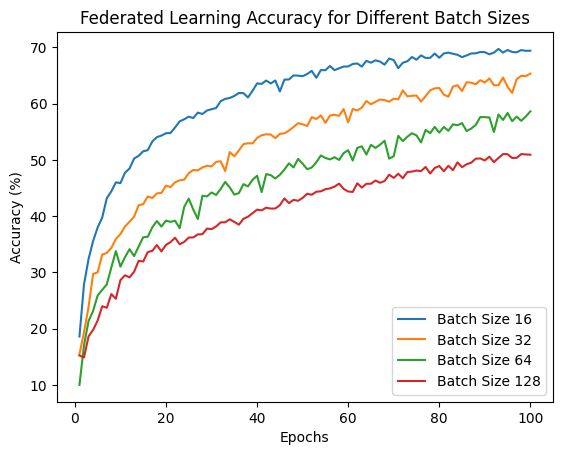

In [63]:
num_clients = 10
epochs = 100
lr = 0.01
batch_sizes = [16, 32, 64, 128]

accuracies = []
for batch_size in batch_sizes:
    model = SimpleCNN()
    
    print("For Batch size: ", batch_size)
    federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=False, alpha=0.5)
    accuracy = federated_training.train(epochs, lr, batch_size)
    accuracies.append(accuracy)

plot_accuracies(batch_sizes, accuracies)

In [66]:
# with varying alpha (Dirchlit)

num_clients = 10
epochs = 200
lr = 0.01
batch_size = 32
alphas = [100, 10, 1, 0.5, 0.01]

accuracies = []
for alpha in alphas:
    model = SimpleCNN()
    
    print("For Alpha: ", alpha)
    federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=False, alpha=alpha)
    accuracy = federated_training.train(epochs, lr, batch_size)
    accuracies.append(accuracy)

plot_accuracies(alphas, accuracies)

For Alpha:  100
Epoch 1, Test Loss: 0.0708, Accuracy: 19.25%
Epoch 2, Test Loss: 0.0673, Accuracy: 25.16%
Epoch 3, Test Loss: 0.0637, Accuracy: 27.32%
Epoch 4, Test Loss: 0.0613, Accuracy: 30.03%
Epoch 5, Test Loss: 0.0594, Accuracy: 32.18%
Epoch 6, Test Loss: 0.0579, Accuracy: 33.82%
Epoch 7, Test Loss: 0.0565, Accuracy: 35.90%
Epoch 8, Test Loss: 0.0554, Accuracy: 37.00%
Epoch 9, Test Loss: 0.0543, Accuracy: 37.69%
Epoch 10, Test Loss: 0.0530, Accuracy: 39.59%
Epoch 11, Test Loss: 0.0517, Accuracy: 40.77%
Epoch 12, Test Loss: 0.0503, Accuracy: 42.95%
Epoch 13, Test Loss: 0.0492, Accuracy: 43.22%
Epoch 14, Test Loss: 0.0480, Accuracy: 45.33%
Epoch 15, Test Loss: 0.0472, Accuracy: 46.19%
Epoch 16, Test Loss: 0.0467, Accuracy: 46.29%
Epoch 17, Test Loss: 0.0466, Accuracy: 46.60%
Epoch 18, Test Loss: 0.0452, Accuracy: 48.86%
Epoch 19, Test Loss: 0.0445, Accuracy: 49.25%
Epoch 20, Test Loss: 0.0442, Accuracy: 49.93%
Epoch 21, Test Loss: 0.0438, Accuracy: 49.88%
Epoch 22, Test Loss: 0.0430

ValueError: num_samples should be a positive integer value, but got num_samples=0

# Performance with reporting fraction and alpha

In [72]:


class FederatedTraining:
    def __init__(self, model, device, trainset, testset, num_clients, iid=True, alpha=0.5):
        self.model = model
        self.device = device
        self.trainset = trainset
        self.testset = testset
        self.num_clients = num_clients
        self.federated = Federated_base(num_clients, trainset.data, trainset.targets, testset.data, testset.targets)
        self.clients = self.federated.create_clients_iid() if iid else self.federated.create_clients_dirichlet(alpha)
        self.client_datasets = {client: DatasetSplit(trainset, indices) for client, indices in self.clients.items()}
        self.test_loader = DataLoader(testset, batch_size=32, shuffle=False)

    def select_clients(self, reporting_fraction):
        num_reporting_clients = int(self.num_clients * reporting_fraction)
        selected_clients = random.sample(list(self.client_datasets.keys()), num_reporting_clients)
        return {client: self.client_datasets[client] for client in selected_clients}

    def train(self, epochs, lr, batch_size, reporting_fraction):
        self.model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        accuracy_list = []

        for epoch in range(epochs):
            client_models = []
            selected_clients = self.select_clients(reporting_fraction)
            client_loaders = {client: DataLoader(dataset, batch_size=batch_size, shuffle=True) for client, dataset in selected_clients.items()}

            for client, loader in client_loaders.items():
                client_model = SimpleCNN().to(self.device)
                client_model.load_state_dict(self.model.state_dict())
                optimizer = optim.SGD(client_model.parameters(), lr=lr)

                client_model.train()
                for images, labels in loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    output = client_model(images)
                    loss = criterion(output, labels)
                    loss.backward()
                    optimizer.step()

                client_models.append(client_model.state_dict())

            new_state_dict = self.model.state_dict()
            for key in new_state_dict.keys():
                new_state_dict[key] = torch.stack([client_model[key].float() for client_model in client_models], 0).mean(0)
            self.model.load_state_dict(new_state_dict)

            test_loss, accuracy = self.evaluate()
            accuracy_list.append(accuracy)
            print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

        return accuracy_list

    def evaluate(self):
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                test_loss += criterion(output, labels).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.dataset)
        accuracy = 100. * correct / len(self.test_loader.dataset)
        return test_loss, accuracy


In [71]:
num_clients = 10
epochs = 10
lr = 0.01
batch_size = 32
reporting_fraction = 0.5
alphas = [100, 10, 1, 0.5, 0.01]

model = SimpleCNN()
federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=True, alpha=0)
accuracies = federated_training.train(epochs, lr, batch_size, reporting_fraction)

Epoch 1, Test Loss: 0.0708, Accuracy: 24.13%
Epoch 2, Test Loss: 0.0673, Accuracy: 24.00%


KeyboardInterrupt: 

In [73]:
def plot_accuracies(alphas, accuracies):
    for alpha in alphas:
        plt.plot(range(1, len(accuracies[alpha]) + 1), accuracies[alpha], label=f'Alpha = {alpha}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Federated Learning Accuracy for Different Concentration Parameter')
    plt.legend()
    plt.show()



Training with alpha: 100
Epoch 1, Test Loss: 0.0718, Accuracy: 13.50%
Epoch 2, Test Loss: 0.0716, Accuracy: 14.78%
Epoch 3, Test Loss: 0.0713, Accuracy: 16.47%
Epoch 4, Test Loss: 0.0709, Accuracy: 19.54%
Epoch 5, Test Loss: 0.0705, Accuracy: 22.84%
Epoch 6, Test Loss: 0.0699, Accuracy: 23.94%
Epoch 7, Test Loss: 0.0691, Accuracy: 24.49%
Epoch 8, Test Loss: 0.0681, Accuracy: 25.71%
Epoch 9, Test Loss: 0.0671, Accuracy: 26.18%
Epoch 10, Test Loss: 0.0660, Accuracy: 26.78%
Epoch 11, Test Loss: 0.0650, Accuracy: 27.55%
Epoch 12, Test Loss: 0.0641, Accuracy: 28.44%
Epoch 13, Test Loss: 0.0633, Accuracy: 28.98%
Epoch 14, Test Loss: 0.0626, Accuracy: 29.40%
Epoch 15, Test Loss: 0.0619, Accuracy: 30.08%
Epoch 16, Test Loss: 0.0613, Accuracy: 31.25%
Epoch 17, Test Loss: 0.0607, Accuracy: 31.35%
Epoch 18, Test Loss: 0.0602, Accuracy: 31.78%
Epoch 19, Test Loss: 0.0598, Accuracy: 32.15%
Epoch 20, Test Loss: 0.0593, Accuracy: 32.73%
Epoch 21, Test Loss: 0.0590, Accuracy: 33.49%
Epoch 22, Test Los

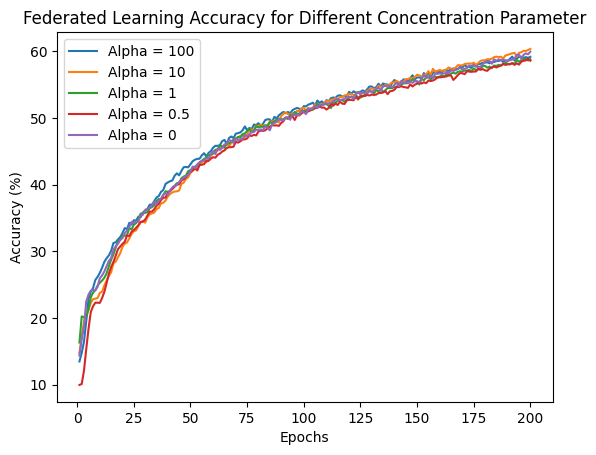

In [79]:
num_clients = 50
epochs = 200
lr = 0.01
batch_size = 32
reporting_fraction = 0.5
alphas = [100, 10, 1, 0.5, 0]

all_accuracies = {}
for alpha in alphas:
    model = SimpleCNN()
    federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=True, alpha=alphas)
    print(f"Training with alpha: {alpha}")
    accuracies = federated_training.train(epochs, lr, batch_size, reporting_fraction)
    all_accuracies[alpha] = accuracies

plot_accuracies(alphas, all_accuracies)


Training with alpha: 100
Epoch 1, Test Loss: 0.0720, Accuracy: 10.02%
Epoch 2, Test Loss: 0.0718, Accuracy: 10.14%
Epoch 3, Test Loss: 0.0717, Accuracy: 14.10%
Epoch 4, Test Loss: 0.0715, Accuracy: 15.12%
Epoch 5, Test Loss: 0.0713, Accuracy: 16.62%
Epoch 6, Test Loss: 0.0710, Accuracy: 17.73%
Epoch 7, Test Loss: 0.0707, Accuracy: 20.33%
Epoch 8, Test Loss: 0.0702, Accuracy: 21.46%
Epoch 9, Test Loss: 0.0696, Accuracy: 23.98%
Epoch 10, Test Loss: 0.0688, Accuracy: 25.40%
Epoch 11, Test Loss: 0.0678, Accuracy: 25.16%
Epoch 12, Test Loss: 0.0667, Accuracy: 26.32%
Epoch 13, Test Loss: 0.0656, Accuracy: 27.54%
Epoch 14, Test Loss: 0.0646, Accuracy: 27.16%
Epoch 15, Test Loss: 0.0638, Accuracy: 27.90%
Epoch 16, Test Loss: 0.0630, Accuracy: 28.96%
Epoch 17, Test Loss: 0.0624, Accuracy: 29.47%
Epoch 18, Test Loss: 0.0617, Accuracy: 30.82%
Epoch 19, Test Loss: 0.0612, Accuracy: 30.39%
Epoch 20, Test Loss: 0.0607, Accuracy: 31.37%
Epoch 21, Test Loss: 0.0605, Accuracy: 31.04%
Epoch 22, Test Los

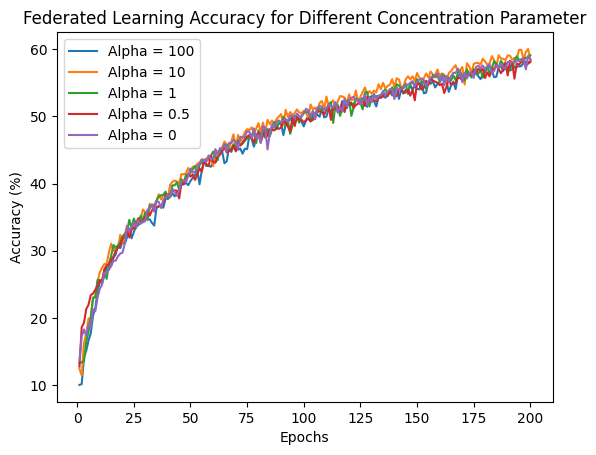

In [80]:
num_clients = 50
epochs = 200
lr = 0.01
batch_size = 32
reporting_fraction = 0.1
alphas = [100, 10, 1, 0.5, 0]

all_accuracies = {}
for alpha in alphas:
    model = SimpleCNN()
    federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=True, alpha=alphas)
    print(f"Training with alpha: {alpha}")
    accuracies = federated_training.train(epochs, lr, batch_size, reporting_fraction)
    all_accuracies[alpha] = accuracies

plot_accuracies(alphas, all_accuracies)

Training with alpha: 100
Epoch 1, Test Loss: 0.0685, Accuracy: 25.37%
Epoch 2, Test Loss: 0.0629, Accuracy: 29.31%
Epoch 3, Test Loss: 0.0600, Accuracy: 32.45%
Epoch 4, Test Loss: 0.0581, Accuracy: 33.86%
Epoch 5, Test Loss: 0.0563, Accuracy: 36.33%
Epoch 6, Test Loss: 0.0541, Accuracy: 38.66%
Epoch 7, Test Loss: 0.0524, Accuracy: 41.54%
Epoch 8, Test Loss: 0.0512, Accuracy: 41.74%
Epoch 9, Test Loss: 0.0497, Accuracy: 43.48%
Epoch 10, Test Loss: 0.0485, Accuracy: 44.99%
Epoch 11, Test Loss: 0.0474, Accuracy: 46.35%
Epoch 12, Test Loss: 0.0466, Accuracy: 46.94%
Epoch 13, Test Loss: 0.0464, Accuracy: 47.40%
Epoch 14, Test Loss: 0.0452, Accuracy: 48.64%
Epoch 15, Test Loss: 0.0445, Accuracy: 49.52%
Epoch 16, Test Loss: 0.0439, Accuracy: 50.60%
Epoch 17, Test Loss: 0.0432, Accuracy: 51.02%
Epoch 18, Test Loss: 0.0427, Accuracy: 51.92%
Epoch 19, Test Loss: 0.0424, Accuracy: 52.43%
Epoch 20, Test Loss: 0.0417, Accuracy: 52.73%
Epoch 21, Test Loss: 0.0413, Accuracy: 53.25%
Epoch 22, Test Los

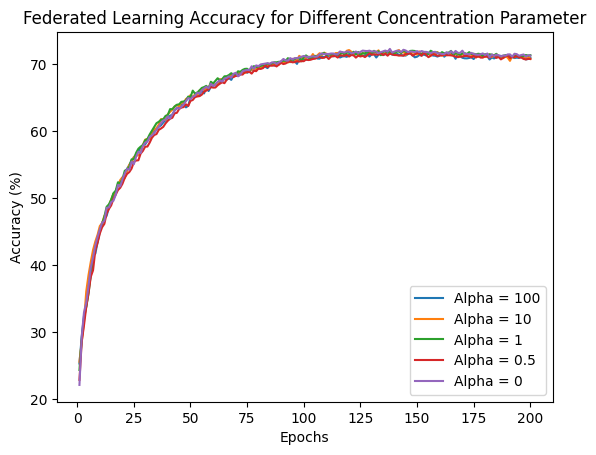

In [81]:
num_clients = 50
epochs = 200
lr = 0.1
batch_size = 32
reporting_fraction = 1
alphas = [100, 10, 1, 0.5, 0]

all_accuracies = {}
for alpha in alphas:
    model = SimpleCNN()
    federated_training = FederatedTraining(model, DEVICE, trainset, testset, num_clients, iid=True, alpha=alphas)
    print(f"Training with alpha: {alpha}")
    accuracies = federated_training.train(epochs, lr, batch_size, reporting_fraction)
    all_accuracies[alpha] = accuracies

plot_accuracies(alphas, all_accuracies)